In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Load data

In [3]:
from scipy.stats import triang, beta

N = int(1e5)

DISTR_TYPE = 'BETA'
assert DISTR_TYPE in ['BETA', 'TRIANG', 'BERNOULLI']

if DISTR_TYPE == 'TRIANG':
    distr = triang(loc=-1, scale=2, c=0.5)
    mu = distr.mean()
    sigma = distr.std()
    lower_bound, upper_bound = -1, 1
    samples = distr.rvs(size=N) - mu
elif DISTR_TYPE == 'BETA':
    distr = beta(10, 30)
    mu = distr.mean()
    sigma = distr.std()
    lower_bound, upper_bound = 0 - mu, 1 - mu
    samples = distr.rvs(size=N) - mu
elif DISTR_TYPE == 'BERNOULLI':
    p = 0.7
    mu = p
    sigma = np.sqrt(p * (1 - p))
    lower_bound, upper_bound = 0 - mu, 1 - mu
    samples = (np.random.rand(N) < p).astype('float') - mu

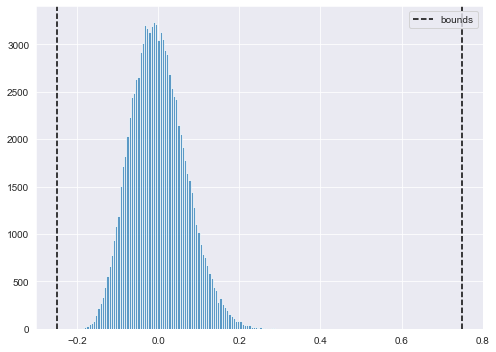

In [4]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.hist(samples, bins=100, alpha=0.7)
    ax.axvline(x=lower_bound, color='black', linestyle='--')
    ax.axvline(x=upper_bound, color='black', linestyle='--', label='bounds')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

## Concentration bounds

In [5]:
from concentration_lib import empirical_student_bound, empirical_bernstein_bound, empirical_bentkus_bound, empirical_hedged_capital_bound, empirical_symmetric_bentkus_efron_bound

def concentration_bounds(sample: np.array, N: int, M: int, delta: float = 0.05, params: dict = {}, verbose: bool = False):
    """
    sample: np.array
    Size must be at least N * M.
    
    N: int
    Sample size for a given estimator.
    
    M: int
    Number of independent repetitions.
    
    delta: float
    Confidence level.
    
    params: dict
    Parameters that influence concentration (bounds, variance, sub-Gaussian...).
    
    verbose: bool
    For tqdm.
    """    
    sample = sample[:N * M].reshape((N, M))
    
    mu_hat = np.zeros((N, M))
    
    boundss_student = np.zeros((2, N, M)) * np.nan
    bounds_student = np.zeros((2, N)) * np.nan
    boundss_bernstein = np.zeros((2, N, M)) * np.nan
    bounds_bernstein = np.zeros((2, N)) * np.nan
    boundss_bentkus = np.zeros((2, N, M)) * np.nan
    bounds_bentkus = np.zeros((2, N)) * np.nan
    boundss_hedged_capital = np.zeros((2, N, M)) * np.nan
    bounds_hedged_capital = np.zeros((2, N)) * np.nan
    boundss_sym_bentkus_efron = np.zeros((2, N, M)) * np.nan
    bounds_sym_bentkus_efron = np.zeros((2, N)) * np.nan
    
    upper_bound = params.get('upper_bound')
    lower_bound = params.get('lower_bound')

    for n in tqdm(range(1, N), disable=not verbose):
        for m in range(M):
            mu_hat[n, m] = np.mean(sample[:n, m])
            boundss_student[:, n, m] = empirical_student_bound(sample[:n, m], delta, side='both', mode='mean')
            boundss_bernstein[:, n, m] = empirical_bernstein_bound(sample[:n, m], delta, upper_bound, lower_bound, side='both', mode='mean')
            boundss_bentkus[:, n, m] = empirical_bentkus_bound(sample[:n, m], delta, upper_bound, lower_bound, side='both', mode='mean')                    
            boundss_hedged_capital[:, n, m] = empirical_hedged_capital_bound(sample[:n, m], delta, upper_bound, lower_bound, side='both', mode='mean')
            boundss_sym_bentkus_efron[:, n, m] = empirical_symmetric_bentkus_efron_bound(sample[:n, m], delta, side='both', mode='mean', root_search_params={'grid_scale': 5000})

        bounds_student[0, n] = np.mean(boundss_student[0, n, :])
        bounds_student[1, n] = np.mean(boundss_student[1, n, :])
        bounds_bernstein[0, n] = np.mean(boundss_bernstein[0, n, :])
        bounds_bernstein[1, n] = np.mean(boundss_bernstein[1, n, :])
        bounds_bentkus[0, n] = np.mean(boundss_bentkus[0, n, :])
        bounds_bentkus[1, n] = np.mean(boundss_bentkus[1, n, :])
        bounds_hedged_capital[0, n] = np.mean(boundss_hedged_capital[0, n, :])
        bounds_hedged_capital[1, n] = np.mean(boundss_hedged_capital[1, n, :])
        bounds_sym_bentkus_efron[0, n] = np.mean(boundss_sym_bentkus_efron[0, n, :])
        bounds_sym_bentkus_efron[1, n] = np.mean(boundss_sym_bentkus_efron[1, n, :])
    
    return {
            'mu_hat': mu_hat,
            'bound': {
                'student': bounds_student,
                'bernstein': bounds_bernstein,
                'bentkus': bounds_bentkus,
                'hedged_capital': bounds_hedged_capital,
                'sym_bentkus_efron': bounds_sym_bentkus_efron,
            },
        }

In [6]:
# Time horizon
n = 75
# Number of independent replications
M = 10
# Confidence level
delta = 0.05

params = {'upper_bound': upper_bound, 'lower_bound': lower_bound}
concentration_dict = concentration_bounds(samples, n, M, delta, params, verbose=True)

  0%|          | 0/74 [00:00<?, ?it/s]

/home/sauxpa/Scool/projects/concentration_lib/concentration_lib/empirical_concentration_bounds.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  * np.log(1 / delta) / (3 * (n - 1))
/home/sauxpa/Scool/projects/concentration_lib/concentration_lib/concentration_bounds.py:278: RuntimeWarning: invalid value encountered in true_divide
  psi = (v - kk * e) / (e - kk * p)
/home/sauxpa/Scool/projects/concentration_lib/concentration_lib/concentration_bounds.py:278: RuntimeWarning: divide by zero encountered in true_divide
  psi = (v - kk * e) / (e - kk * p)


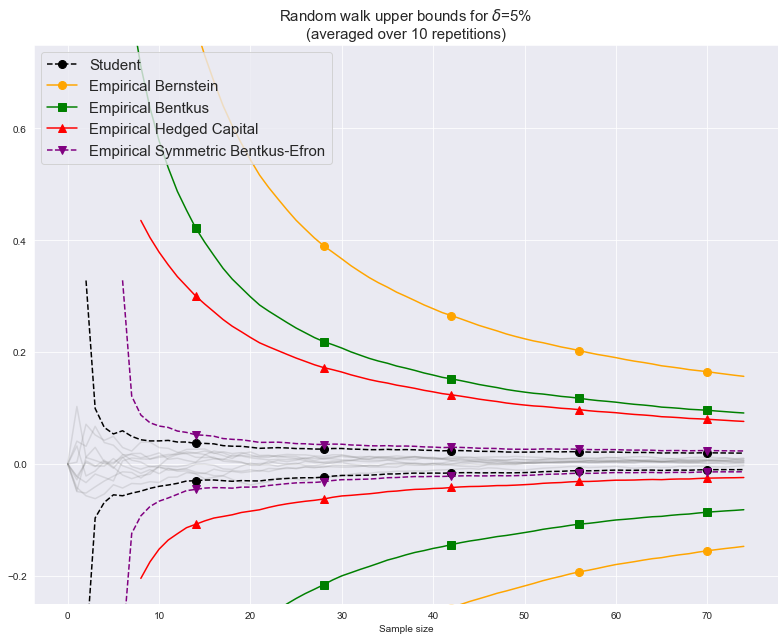

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 9), nrows=1, ncols=1)
    
    mu_hat = np.mean(concentration_dict['mu_hat'], axis=1)
    markfreq = 5
    markevery = n // markfreq - 1
    
    ax.plot(concentration_dict['mu_hat'], color='grey', alpha=0.2)
    ax.plot(mu_hat - concentration_dict['bound']['student'][0, :], color='black', marker='o', markersize=8, markevery=markevery, linestyle='dashed', label='Student')
    ax.plot(mu_hat + concentration_dict['bound']['student'][1, :], color='black', marker='o', markersize=8, markevery=markevery, linestyle='dashed')
    ax.plot(mu_hat - concentration_dict['bound']['bernstein'][0, :], color='orange', marker='o', markersize=8, markevery=markevery, label='Empirical Bernstein')
    ax.plot(mu_hat + concentration_dict['bound']['bernstein'][1, :], color='orange', marker='o', markersize=8, markevery=markevery)
    ax.plot(mu_hat - concentration_dict['bound']['bentkus'][0, :], color='green', marker='s', markersize=8, markevery=markevery, label='Empirical Bentkus')
    ax.plot(mu_hat + concentration_dict['bound']['bentkus'][1, :], color='green', marker='s', markersize=8, markevery=markevery)
    ax.plot(mu_hat - concentration_dict['bound']['hedged_capital'][0, :], color='red', marker='^', markersize=8, markevery=markevery, label='Empirical Hedged Capital')
    ax.plot(mu_hat + concentration_dict['bound']['hedged_capital'][1, :], color='red', marker='^', markersize=8, markevery=markevery)
    ax.plot(mu_hat - concentration_dict['bound']['sym_bentkus_efron'][0, :], color='purple', marker='v', markersize=8, markevery=markevery, linestyle='dashed', label='Empirical Symmetric Bentkus-Efron')
    ax.plot(mu_hat + concentration_dict['bound']['sym_bentkus_efron'][1, :], color='purple', marker='v', markersize=8, markevery=markevery,  linestyle='dashed')
       
    ax.set_xlabel('Sample size')
    ax.set_ylim([lower_bound, upper_bound])
    ax.legend(loc='upper left', prop={'size': 15})
    ax.set_title('Random walk upper bounds for $\delta$={:.0%}\n(averaged over {:.0f} repetitions)'.format(delta, M), fontsize=15)

    plt.tight_layout()
    plt.show()